In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import sys
import pickle
import pandas as pd
from tqdm import tqdm

In [3]:
sys.path.append('/home/akumar/nse/neural_control')

In [4]:
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes
from decoders import lr_decode_windowed, expand_state_space

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load the sparse dataframe
with open('/mnt/Secondary/data/postprocessed/sparse_decoding_df.dat', 'rb') as f:
    df = pickle.load(f)
# PCA Hoyer
with open('/mnt/Secondary/data/postprocessed/hoyer_pca_decoding.pkl', 'rb') as f:
    dfp = pickle.load(f)

In [6]:
df = pd.DataFrame(df)
df_pca = pd.DataFrame(dfp)

In [7]:
# Assess decoding performance of each method across data files as alpha is increased
df_pca = apply_df_filters(df_pca, dimreduc_method='sPCA')
#df_pca = apply_df_filters(df, dimreduc_method='PCA')
df_fcca = apply_df_filters(df, dimreduc_method='FCCA_prox')

In [8]:
alphaf = np.unique(df_fcca['alpha'].values)
alphap = np.unique(df_pca['alpha'].values)
data_filesp = np.unique(df_pca['data_file'].values)
data_filesf = np.unique(df_fcca['data_file'].values)
data_files = np.intersect1d(data_filesp, data_filesf)

In [9]:
r2f = np.zeros((data_files.size, alphaf.size, 5, 3))
r2p = np.zeros((data_files.size, alphap.size, 5, 3))
sparsityf = np.zeros((data_files.size, alphaf.size, 5))
sparsityp = np.zeros((data_files.size, alphap.size, 5))
for i, data_file in tqdm(enumerate(data_files)):
    for fold_idx in np.arange(5):  
        df_fcca_ = apply_df_filters(df_fcca, data_file=data_file, fold_idx=fold_idx)
        df_pca_ = apply_df_filters(df_pca, data_file=data_file, fold_idx=fold_idx)
        for j, alpha in enumerate(alphaf):
            df_fcca__ = apply_df_filters(df_fcca_, alpha=alpha)
            assert(df_fcca__.shape[0] == 1)
            r2f[i, j, fold_idx] = df_fcca__.iloc[0]['r2']
            l = calc_loadings(df_fcca__.iloc[0]['coef'])
            sparsityf[i, j, fold_idx] = np.sum(l < 1e-5)/l.shape[0]


            #sparsityf[i, j, fold_idx] = np.sum(np.linalg.norm(df_fcca__.iloc[0]['coef'], axis=1) < 1e-3)/df_fcca__.iloc[0]['coef'].shape[0]

        for j, alpha in enumerate(alphap):
            df_pca__ = apply_df_filters(df_pca_, alpha=alpha)
            assert(df_pca__.shape[0] == 1)
            r2p[i, j, fold_idx] = df_pca__.iloc[0]['r2']
            l = calc_loadings(df_pca__.iloc[0]['coef'])
            sparsityp[i, j, fold_idx] = np.sum(l < 1e-5)/l.shape[0]

            #sparsityp[i, j, fold_idx] = np.sum(np.linalg.norm(df_pca__.iloc[0]['coef'], axis=1) < 1e-3)/df_pca__.iloc[0]['coef'].shape[0]

35it [00:08,  4.34it/s]


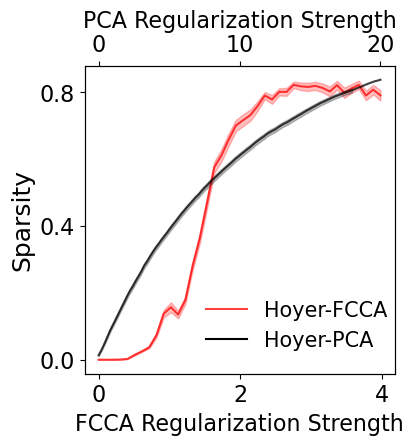

In [10]:
# Plot the average sparsity as a function of the regularization parameter
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Twin the x axis
ax2 = ax.twiny()
ax.plot(alphaf[:-10], np.mean(sparsityf, axis=(0, 2))[:-10], color='r', alpha=0.75, label='Hoyer-FCCA')
ax2.plot(alphap, np.mean(sparsityp, axis=(0, 2)), color='k', alpha=0.75)

ax.fill_between(alphaf[:-10], np.mean(sparsityf, axis=(0, 2))[:-10] - np.std(sparsityf, axis=(0, 2))[:-10]/np.sqrt(sparsityf.shape[0] * sparsityf.shape[2]), 
                np.mean(sparsityf, axis=(0, 2))[:-10] + np.std(sparsityf, axis=(0, 2))[:-10]/np.sqrt(sparsityf.shape[0] * sparsityf.shape[2]), 
                color='r', alpha=0.25)
ax2.fill_between(alphap[:-10], np.mean(sparsityp, axis=(0, 2))[:-10] - np.std(sparsityp, axis=(0, 2))[:-10]/np.sqrt(sparsityp.shape[0] * sparsityp.shape[2]), 
                np.mean(sparsityp, axis=(0, 2))[:-10] + np.std(sparsityp, axis=(0, 2))[:-10]/np.sqrt(sparsityp.shape[0] * sparsityp.shape[2]), 
                color='k', alpha=0.25)
# Dummy plot for legend
ax.plot(np.nan, color='k', label='Hoyer-PCA')

ax.set_ylabel('Sparsity', fontsize=18)
ax.set_yticks([0.0, 0.4, 0.8])
ax.set_yticklabels([0.0, 0.4, 0.8], fontsize=16)
ax.set_xticks([0, 2, 4])
ax.set_xticklabels([0, 2, 4], fontsize=16)
ax.set_xlabel('FCCA Regularization Strength', fontsize=16)
ax2.set_xticks([0, 10, 20])
ax2.set_xticklabels([0, 10, 20], fontsize=16)
ax2.set_xlabel('PCA Regularization Strength', fontsize=16)
ax.legend(bbox_to_anchor=(0.33, 0.3), fontsize=15, frameon=False)
#fig.savefig('sparsity_vs_reg_grant_pcal1.pdf', bbox_inches='tight')

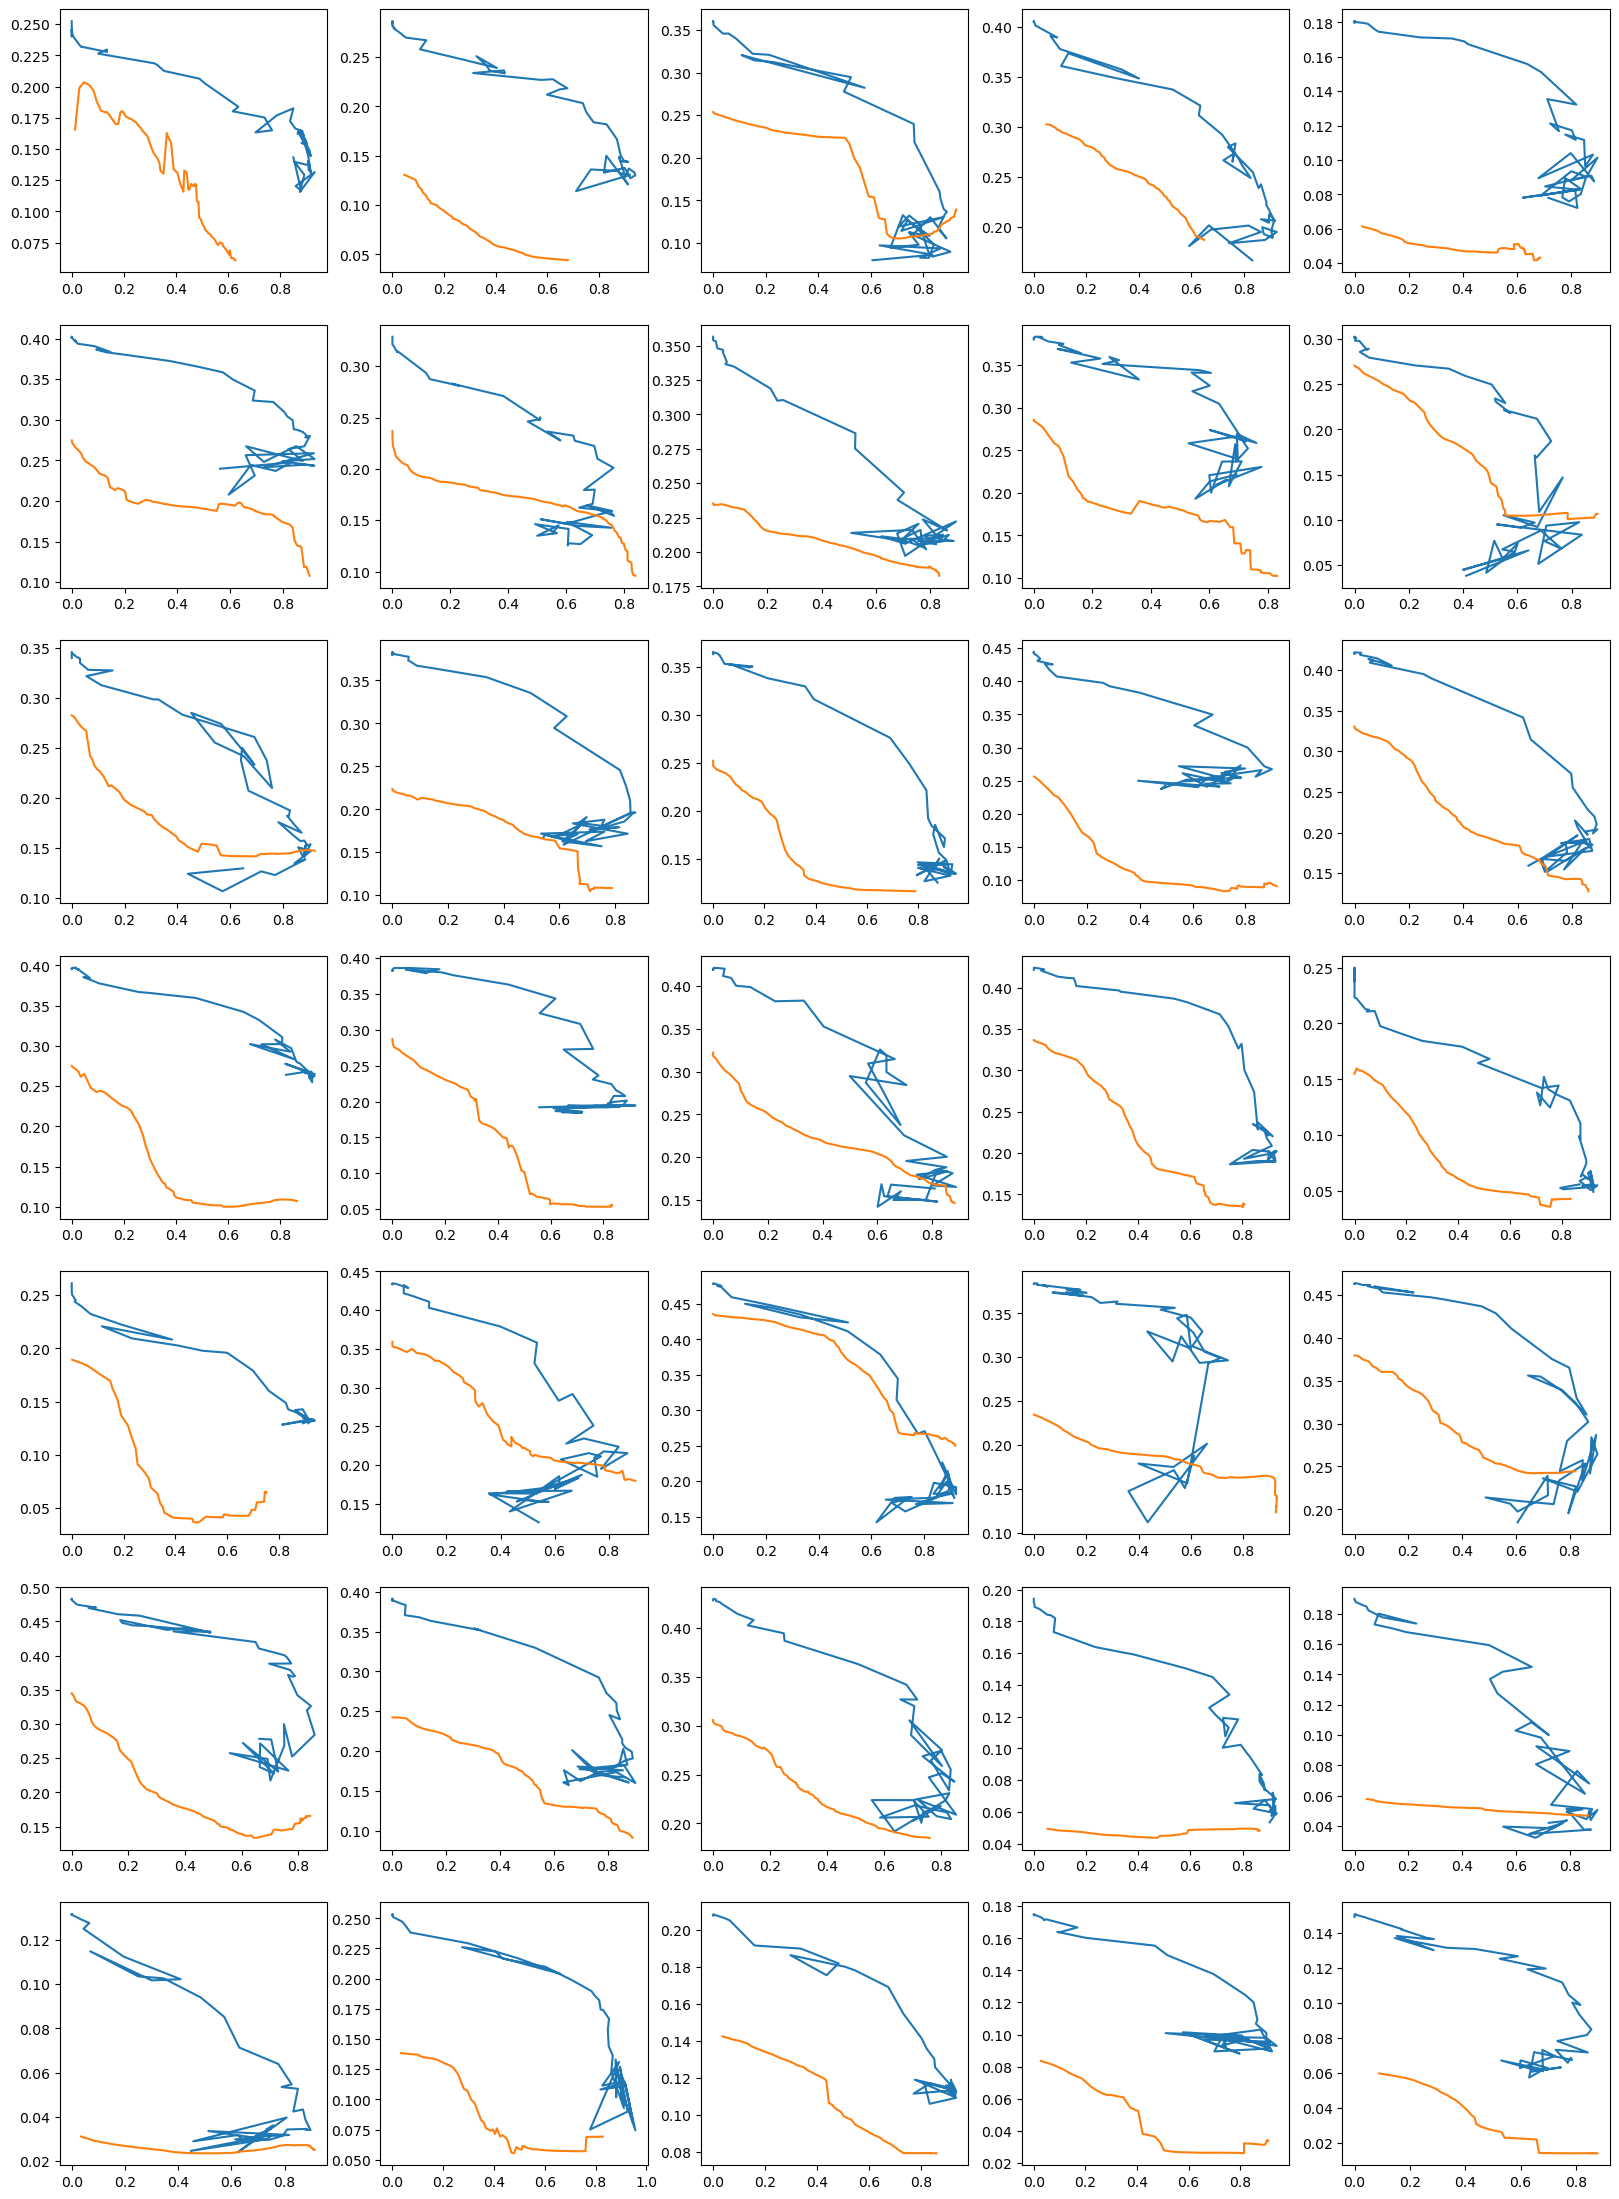

In [11]:
# For each data file, plot the mean r2 across folds as a function of alpha
r2f_mean = np.mean(r2f, axis=2)
r2p_mean = np.mean(r2p, axis=2)

sparsityf_mean = np.mean(sparsityf, axis=2)
sparsityp_mean = np.mean(sparsityp, axis=2)

fig, ax = plt.subplots(7, 5, figsize=(20, 28))
for i, data_file in enumerate(data_files):
    a = ax[np.unravel_index(i, (7, 5))]
    a.plot(sparsityf_mean[i, :], r2f_mean[i, :, 1], label='FCCA')
    a.plot(sparsityp_mean[i, :], r2p_mean[i, :, 1], label='PCA')

In [63]:
r2f_mean.shape

(35, 50, 3)

In [12]:
alpha_threshold_f = np.zeros(data_files.size)
alpha_threshold_p = np.zeros(data_files.size)

for i, data_file in enumerate(data_files):
    for j, alpha in enumerate(alphaf):
        if r2f_mean[i, j, 1] < 0.5 * r2f_mean[i, 0, 1]:
            alpha_threshold_f[i] = alpha
            break

    for j, alpha in enumerate(alphap):
        if r2p_mean[i, j, 1] < 0.5 * r2p_mean[i, 0, 1]:
            alpha_threshold_p[i] = alpha
            break

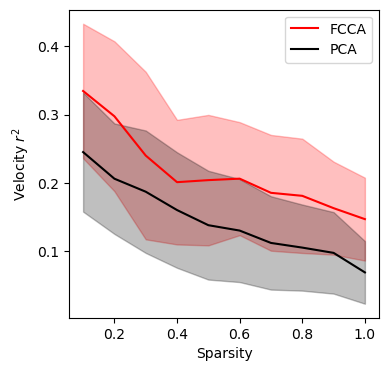

In [65]:
# Histogram indices by sparsity
bins = np.linspace(0, 1, 11)
bin_indices_f = np.digitize(sparsityf_mean.flatten(), bins)
bin_indices_p = np.digitize(sparsityp_mean.flatten(), bins)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(bins[1:], [np.mean(r2f_mean[..., 1].flatten()[bin_indices_f == i]) for i in np.arange(1, 11)], label='FCCA', color='r')
ax.fill_between(bins[1:], [np.mean(r2f_mean[..., 1].flatten()[bin_indices_f == i]) - np.std(r2f_mean[..., 1].flatten()[bin_indices_f == i]) for i in np.arange(1, 11)], 
                          [np.mean(r2f_mean[..., 1].flatten()[bin_indices_f == i]) + np.std(r2f_mean[..., 1].flatten()[bin_indices_f == i]) for i in np.arange(1, 11)], 
                          color='r', alpha=0.25)
ax.fill_between(bins[1:], [np.mean(r2p_mean[..., 1].flatten()[bin_indices_p == i]) - np.std(r2p_mean[..., 1].flatten()[bin_indices_p == i]) for i in np.arange(1, 11)], 
                          [np.mean(r2p_mean[..., 1].flatten()[bin_indices_p == i]) + np.std(r2p_mean[..., 1].flatten()[bin_indices_p == i]) for i in np.arange(1, 11)], 
                          color='k', alpha=0.25)

ax.plot(bins[1:], [np.mean(r2p_mean[..., 1].flatten()[bin_indices_p == i]) for i in np.arange(1, 11)], label='PCA', color='k')
ax.legend()
ax.set_xlabel('Sparsity')
ax.set_ylabel('Velocity ' + r'$r^2$')
#fig.savefig('decoding_vs_sparsity.pdf', bbox_inches='tight', pad_inches=0)

In [13]:
# For each data file, select the regularization strength at which the decoding performance achieves 0.75 of the unregularized r2. Use this coefficient to
# calculate leverage scores. Take the minimum leverage score across folds, rather than the mean

loadings_pca = []
idxs_pca = []
loadings_fca = []
idxs_fca = []

for i, data_file in tqdm(enumerate(data_files)):
    loadings_fold_fca = []
    loadings_fold_pca = []
    for fold_idx in range(5):            

        df_ = apply_df_filters(df_fcca, data_file=data_file, fold_idx=fold_idx, alpha=alphaf[np.argmin(np.abs(alphaf - alpha_threshold_f[i]))])
        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        loadings_fold_fca.append(calc_loadings(V))

        df_ = apply_df_filters(df_pca, data_file=data_file, fold_idx=fold_idx, alpha=alphap[np.argmin(np.abs(alphap - alpha_threshold_p[i]))])
        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        loadings_fold_pca.append(calc_loadings(V))

    loadings_fca.extend(np.min(loadings_fold_fca, axis=0))
    loadings_pca.extend(np.min(loadings_fold_pca, axis=0))

# threshold
threshold = 1e-4
loadings_fca = np.array(loadings_fca)
loadings_pca = np.array(loadings_pca)

loadings_fca[loadings_fca < threshold] = 0
loadings_pca[loadings_pca < threshold] = 0

35it [00:00, 55.29it/s]


/tmp/ipykernel_16206/148035384.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(loadings_fca), np.log10(loadings_pca))


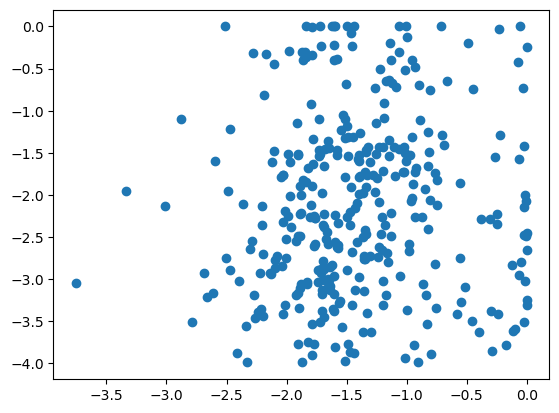

In [18]:
plt.scatter(np.log10(loadings_fca), np.log10(loadings_pca))

In [19]:
# to-do: compare side by side on the same axes as the original plot
# Alternatively: choose a consistent sparsity threhsold rather than an alpha threshold

In [20]:
alphaf.shape

(50,)

In [21]:
sparsityf_mean.shape

(35, 50)

In [14]:
import matplotlib.cm as cm
import matplotlib.colors as colors


35it [00:00, 55.77it/s]
35it [00:00, 54.80it/s]
/tmp/ipykernel_18000/4057673899.py:68: RuntimeWarning: divide by zero encountered in log10
  h = a.scatter(np.log10(x1), np.log10(x2), alpha=1.0, c=ratio, edgecolors=(0.1, 0.1, 0.1, 0.0), linewidth=0.1, s=10, cmap=cmap_new)
35it [00:00, 56.62it/s]
35it [00:00, 52.33it/s]


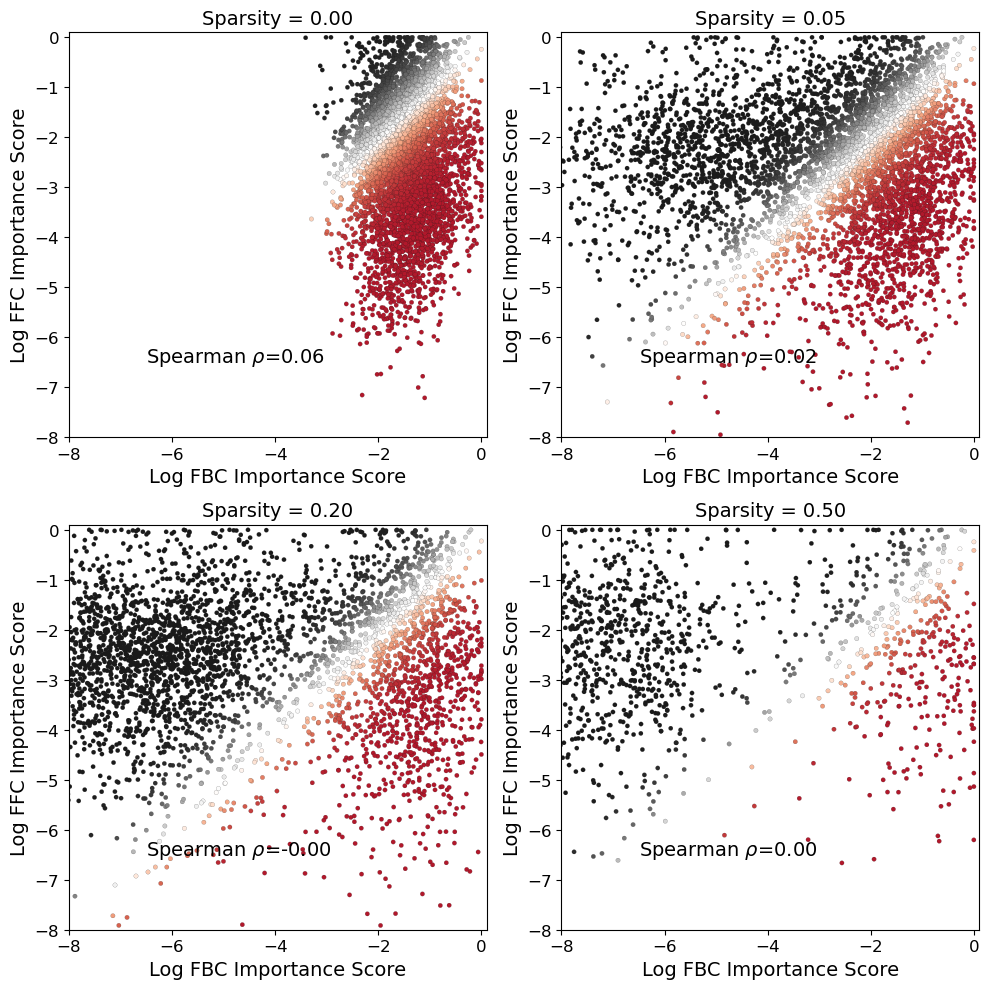

In [18]:
# For each data file, select the regularization strength at which the decoding performance achieves 0.75 of the unregularized r2. Use this coefficient to
# calculate leverage scores. Take the minimum leverage score across folds, rather than the mean
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sparsities = [0, 0.05, 0.2, 0.5]

for i in range(len(sparsities)):
    a = ax[np.unravel_index(i, (2, 2))]
    loadings_pca = []
    idxs_pca = []
    loadings_fca = []
    idxs_fca = []

    sparsity = sparsities[i]

    for i, data_file in tqdm(enumerate(data_files)):
        loadings_fold_fca = []
        loadings_fold_pca = []
        for fold_idx in range(5):            

            # Select the first index where the sparsity is greater than the desired sparsity
            try:
                sparsity_index = np.arange(sparsityf_mean.shape[1])[sparsityf_mean[i, :] > sparsity][0]
            except:
                sparsity_index = 49

            sparsity_index = np.argmin(np.abs(sparsityf_mean[i, :] - sparsity))
#            print(sparsity_index)
            df_ = apply_df_filters(df_fcca, data_file=data_file, fold_idx=fold_idx, alpha=alphaf[sparsity_index])
            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            loadings_fold_fca.append(calc_loadings(V))

            try:
                sparsity_index = np.arange(sparsityp_mean.shape[1])[sparsityp_mean[i, :] > sparsity][0]
            except:
                sparsity_index = 49
#            print(sparsity_index)
            df_ = apply_df_filters(df_pca, data_file=data_file, fold_idx=fold_idx, alpha=alphap[sparsity_index])
            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            loadings_fold_pca.append(calc_loadings(V))

        loadings_fca.extend(np.min(loadings_fold_fca, axis=0))
        loadings_pca.extend(np.min(loadings_fold_pca, axis=0))

    # threshold
    # threshold = 1e-5
    # loadings_fca = np.array(loadings_fca)
    # loadings_pca = np.array(loadings_pca)

    # loadings_fca[loadings_fca < threshold] = 0
    # loadings_pca[loadings_pca < threshold] = 0

    x1 = np.array(loadings_fca)
    x2 = np.array(loadings_pca)

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    cmap_new = truncate_colormap(cm.RdGy_r, 0., 0.9)

    ratio = np.divide(x1, x1 + x2)

    h = a.scatter(np.log10(x1), np.log10(x2), alpha=1.0, c=ratio, edgecolors=(0.1, 0.1, 0.1, 0.0), linewidth=0.1, s=10, cmap=cmap_new)

    #cbar = plt.colorbar(h, cax=fig.add_axes([0.925, 0.25, 0.025, 0.5]))
    #cbar.set_label('Relative FBC Importance')
    #cbar.ax.set_yticks([0, 0.5, 1.])
    # Annotate with the spearman-r
    r = scipy.stats.spearmanr(x1, x2)[0]

    a.set_xlim([-8, 0.1])
    a.set_ylim([-8, 0.1])

    a.set_xlabel('Log FBC Importance Score', fontsize=14)
    a.set_ylabel('Log FFC Importance Score', fontsize=14)
    a.tick_params(axis='both', labelsize=12)
    a.annotate('Spearman ' + r'$\rho$' +'=%.2f' % r, (-6.5, -6.5), fontsize=14)

    a.set_title('Sparsity = %.2f' % sparsity, fontsize=14)
fig.tight_layout()
#fig.savefig('hoyervsl1_scatter.pdf')

35it [00:00, 56.94it/s]
/tmp/ipykernel_18000/2552318237.py:63: RuntimeWarning: divide by zero encountered in log10
  h = a.scatter(np.log10(x1), np.log10(x2), alpha=1.0, c=ratio, edgecolors=(0.1, 0.1, 0.1, 0.0), linewidth=0.1, s=10, cmap=cmap_new)


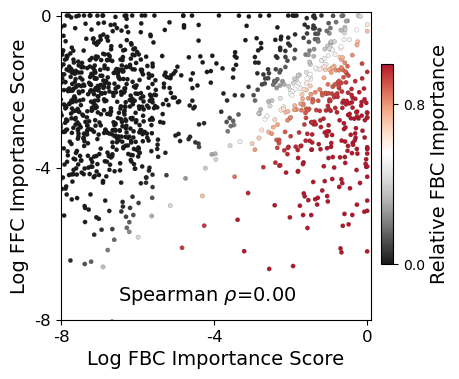

In [38]:
# Take the last panel 
fig, a = plt.subplots(1, 1, figsize=(4, 4))

loadings_pca = []
idxs_pca = []
loadings_fca = []
idxs_fca = []

sparsity = sparsities[-1]

for i, data_file in tqdm(enumerate(data_files)):
    loadings_fold_fca = []
    loadings_fold_pca = []
    for fold_idx in range(5):            

        # Select the first index where the sparsity is greater than the desired sparsity
        try:
            sparsity_index = np.arange(sparsityf_mean.shape[1])[sparsityf_mean[i, :] > sparsity][0]
        except:
            sparsity_index = 49

        sparsity_index = np.argmin(np.abs(sparsityf_mean[i, :] - sparsity))
#            print(sparsity_index)
        df_ = apply_df_filters(df_fcca, data_file=data_file, fold_idx=fold_idx, alpha=alphaf[sparsity_index])
        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        loadings_fold_fca.append(calc_loadings(V))

        try:
            sparsity_index = np.arange(sparsityp_mean.shape[1])[sparsityp_mean[i, :] > sparsity][0]
        except:
            sparsity_index = 49
#            print(sparsity_index)
        df_ = apply_df_filters(df_pca, data_file=data_file, fold_idx=fold_idx, alpha=alphap[sparsity_index])
        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        loadings_fold_pca.append(calc_loadings(V))

    loadings_fca.extend(np.min(loadings_fold_fca, axis=0))
    loadings_pca.extend(np.min(loadings_fold_pca, axis=0))

# threshold
# threshold = 1e-5
# loadings_fca = np.array(loadings_fca)
# loadings_pca = np.array(loadings_pca)

# loadings_fca[loadings_fca < threshold] = 0
# loadings_pca[loadings_pca < threshold] = 0

x1 = np.array(loadings_fca)
x2 = np.array(loadings_pca)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap_new = truncate_colormap(cm.RdGy_r, 0., 0.9)

ratio = np.divide(x1, x1 + x2)

h = a.scatter(np.log10(x1), np.log10(x2), alpha=1.0, c=ratio, edgecolors=(0.1, 0.1, 0.1, 0.0), linewidth=0.1, s=10, cmap=cmap_new)

#cbar = plt.colorbar(h, cax=fig.add_axes([0.925, 0.25, 0.025, 0.5]))
#cbar.set_label('Relative FBC Importance')
#cbar.ax.set_yticks([0, 0.5, 1.])
# Annotate with the spearman-r
r = scipy.stats.spearmanr(x1, x2)[0]

a.set_xlim([-8, 0.1])
a.set_ylim([-8, 0.1])
a.set_yticks([0, -4, -8])
a.set_yticklabels([0, -4, -8], fontsize=12)

a.set_xticks([0, -4, -8])
a.set_xticklabels([0, -4, -8], fontsize=12)

a.set_xlabel('Log FBC Importance Score', fontsize=14)
a.set_ylabel('Log FFC Importance Score', fontsize=14)
a.tick_params(axis='both', labelsize=12)


a.annotate('Spearman ' + r'$\rho$' +'=%.2f' % r, (-6.5, -7.5), fontsize=14)



# Highlight top neurons by modulating size and linewidth
# s = 10 * np.zeros(x1.shape)
# s[top_neurons_fca] = 25
# s[top_neurons_pca] = 25
# h = ax.scatter(np.log10(x1), np.log10(x2), alpha=1.0, c=ratio, edgecolors=(0.0, 0.0, 0.0, 0.0), linewidth=0.75, s=s, cmap=cmap_new)

cbar = fig.colorbar(h, ticks=[0., 0.8], cax=fig.add_axes([0.925, 0.25, 0.03, 0.5]))
#cbar = plt.colorbar(h, cax=fig.add_axes([0.925, 0.25, 0.025, 0.5]))
cbar.set_label('Relative FBC Importance', fontsize=14)
# cbar.ax.set_yticks([0, 0.4, 0.8], labelsize=14)
# Annotate with the spearman-r
r = scipy.stats.spearmanr(x1, x2)[0]
#a.set_title('Sparsity = %.2f' % sparsity, fontsize=14)
fig.savefig('hoyer_scatter_grant.pdf')

### Establishing Dynamic Range for Hoyer PCA

In [12]:
from FCCA.proximal import HoyerPCA

In [13]:
import glob

In [14]:
data_files = glob.glob('/mnt/Secondary/data/sabes/*.mat')

In [15]:
dat = load_sabes(data_files[4])

KeyError: 'spike_rates.squeeze'

In [17]:
X =dat['spike_rates'].squeeze()

In [22]:
alphas = np.linspace(0, 5)
sparsity = np.zeros(alphas.size)
for i, alpha in tqdm(enumerate(alphas)):
    h = HoyerPCA(alpha=alpha, n_components=6, PCA_init=True)
    h.fit(X)
    coef = h.components_.T
    loadings = calc_loadings(coef)
    sparsity[i] = np.sum(loadings < 1e-4)/loadings.size

50it [41:16, 49.53s/it]


ValueError: x and y must have same first dimension, but have shapes (1,) and (50,)

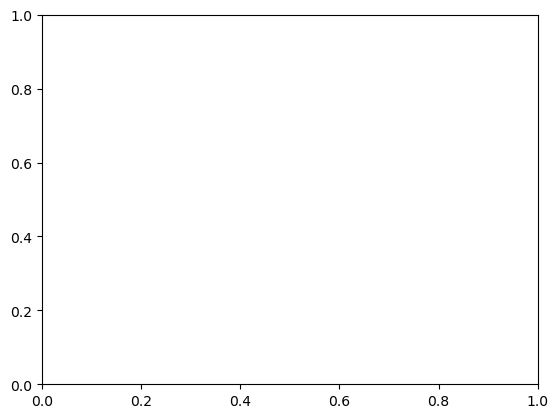

### Use BIC to define decoding performance